# Build SSD with DFG IR

This tutorial illustrates how to construct a Single Shot MultiBox Detector (SSD) by using a framework-independent **Intermediate Representation** (IR) that describes **Data-Flow Graph** (DFG). This IR contains primitives that describe nodes and their connections in the DFG and what operations will these nodes process. Nodes in DFG also carry auxilliary information that directs further optimisation, such as design space exploration. We have a tool that automatically generates DFG IR from the model, which we call **Plumebr**.

We will walk through the basic syntax of the IR, present how the MNIST is built with the IR can be visualised and verified and show the instructions to train in a TensorFlow back-end. 

## What is Plumber?

Before we do that, Let's introduce **Plumber** first.

**Plumber** is a tool-chain for generating high-performance FPGA-based CNN inference system. **Plumber** takes high-level CNN descriptions and training data (in TensorFlow) as input, and outputs an optimised runnable software program together with a hardware design.

We have installed **Plumber** here, you can use it directly. 

### Generating DFG IR from Tensorflow Model 

We can use the plumebr api to generate DFG IR. Of course, Plumebr also provides a command line tool for you to use. In the following tutorials, there will be an introduction.

In [1]:
from plumber.utils import gen_dfg

# We have provided a trained SSD model in advance.
dfg = gen_dfg('../data/ssd.pb', input_image_shape=[1, 256, 256, 3])
dfg.save_dfg_def('../data/ssd.pbtxt', is_bin=False)
print(dfg.as_dfg_def())

We cannot find "data_format" in the placeholder. We will try to resolve "data_format" in post-process


name: ""
node {
  name: "img_input"
  op: "Input"
  device: CPU
  type: T_FLOAT
  input_op_param {
    shape {
      dim: 3
      dim: 256
      dim: 256
    }
  }
}
node {
  name: "ssd_preprocessing_train/resize_image/reshape"
  input: "img_input"
  op: "Reshape"
  device: CPU
  type: T_FLOAT
  reshape_op_param {
    shape {
      dim: 1
      dim: 3
      dim: 256
      dim: 256
    }
  }
}
node {
  name: "ssd_KYnet_v2/conv1_1/conv2d"
  input: "ssd_preprocessing_train/resize_image/reshape"
  op: "Conv2D"
  device: CPU
  type: T_FLOAT
  conv2d_op_param {
    depth: 16
    kernel_size: 3
    pad: 1
    stride: 1
    activation_fn: "Relu"
    use_maxpool_2x2: false
    use_batch_norm: false
    use_bias: true
    use_relu: true
  }
}
node {
  name: "ssd_KYnet_v2/conv2_1/conv2d"
  input: "ssd_KYnet_v2/conv1_1/conv2d"
  op: "Conv2D"
  device: CPU
  type: T_FLOAT
  conv2d_op_param {
    depth: 32
    kernel_size: 3
    pad: 1
    stride: 1
    activation_fn: "Relu"
    use_maxpool_2x2: fal

## DFG IR Syntax
**DFG IR** file structure is very simple, it has a name attribute, and node attribute. 
node can be repeated more than once, but the name has to be unique. 

and more info, you can see [link](https://corerain.github.io/plumber-docs/topics/dfg-ir.html).

For example:
```
name: "test"
node {
  name: "img_input"
  op: "Input"
  device: CPU
  type: T_FLOAT
  input_op_param {
    shape {
      dim: 32
      dim: 28
      dim: 28
      dim: 1
    }
  }
}
node {
  name: "conv1"
  input: "img_input"
  op: "Conv2D"
  device: CPU
  type: T_FLOAT
  conv2d_op_param {
    depth: 32
    kernel_size: 5
    pad: 2
    stride: 1
    activation_fn: "Relu"
    use_bias: true
  }
}
node {
  name: "pool1"
  input: "conv1"
  op: "MaxPool2D"
  device: CPU
  type: T_FLOAT
  max_pool2d_op_param {
    kernel_size: 2
    stride: 2
  }
}
node {
  name: "fc3"
  input: "flatten"
  op: "FullyConnected"
  device: CPU
  type: T_FLOAT
  fullyconnected_op_param {
    rows: 1024
    activation_fn: "Relu"
  }
}
```
In node:
- ``name``: Used to specify the name of the node.
- ``op``: Used to specify node's Operation type.
- ``device``: Specifies the execution device for node, such as ``CPU``, ``FPGA``.
- ``type``: Used to specify node's data type.
- ``input``: Used to specify the input of the current node.
- ``xxx_op_param``: is a private parameter of node. It has various parameters that only belong to this op. 
  Its name follows the rules of xxx_op_param, xxx is the lowercase of the node's op value, followed by a fixed format. 
  The exception is ``MaxPool2D``, which is ``max_pool2d_op_param``.

### Input Node
```
node {
  name: "img_input"
  op: "Input"
  device: CPU
  type: T_FLOAT
  input_op_param {
    shape {
      dim: 32
      dim: 28
      dim: 28
      dim: 1
    }
  }
}
```
If you want to construct an input like tf.placeholder for Tensorflow:


In [2]:
import tensorflow as tf

# Use TensorFlow
img_input = tf.placeholder(tf.float32, shape=[32, 28, 28, 1], name='img_input')
print("Tensorflow: ", img_input)

Tensorflow:  Tensor("img_input:0", shape=(32, 28, 28, 1), dtype=float32)


In [3]:
# Use Plumber
from plumber.dfg.nodes import DFGInputNode

input_node = DFGInputNode('img_input', shape=[32, 28, 28, 1])
print("DFG IR: ", input_node.tf_api())
print("------------------------------")
print("DFG IR pbtxt")
print(input_node.as_dfg_node_def())

DFG IR:  Tensor("img_input_1:0", shape=(32, 28, 28, 1), dtype=float32)
------------------------------
DFG IR pbtxt
name: "img_input"
op: "Input"
device: CPU
type: T_FLOAT
input_op_param {
  shape {
    dim: 32
    dim: 28
    dim: 28
    dim: 1
  }
}



### Conv2D Node
```
node {
  name: "conv1"
  input: "img_input"
  op: "Conv2D"
  device: CPU
  type: T_FLOAT
  conv2d_op_param {
    depth: 32
    kernel_size: 5
    pad: 2
    stride: 1
    activation_fn: "Relu"
    use_bias: true
  }
}
```
- depth: Integer, the dimensionality of the output space.
- kernel_size: Integer, specifying the height and width of the 2D convolution window. We currently only support the same size kernel_size.
- pad: Integer, “valid” is 0, “same” is 1.
- stride: Integer, specifying the strides of the convolution along the height and width. We currently only support the same stride value.
- activation_fn: String, Activate the function name. If it is not needed, fill in the null character.

In [4]:
import tensorflow as tf

# Use TensorFlow
conv1 = tf.layers.conv2d(img_input, 32, 5, padding='same', name="conv1")
print(conv1)

Tensor("conv1/BiasAdd:0", shape=(32, 28, 28, 32), dtype=float32)


In [5]:
# Use Plumber

from plumber.dfg.nodes import DFGConv2DNode

conv1_node = DFGConv2DNode('conv1_1', num_filters=32, kernel_size=5, padding=1, stride=1, activation="Relu")
conv1_node.inputs.append('img_input')
print("DFG IR: ", conv1_node.tf_api(img_input))
print("------------------------------")
print("DFG IR pbtxt")
print(conv1_node.as_dfg_node_def())

DFG IR:  Tensor("conv1_1_1/Relu:0", shape=(32, 28, 28, 32), dtype=float32)
------------------------------
DFG IR pbtxt
name: "conv1_1"
input: "img_input"
op: "Conv2D"
device: CPU
type: T_FLOAT
conv2d_op_param {
  depth: 32
  kernel_size: 5
  pad: 1
  stride: 1
  activation_fn: "Relu"
  use_maxpool_2x2: false
  use_batch_norm: false
  use_bias: false
  use_relu: true
}



### MaxPool2D Node
```
node {
  name: "pool1"
  input: "conv1"
  op: "MaxPool2D"
  device: CPU
  type: T_FLOAT
  max_pool2d_op_param {
    kernel_size: 2
    stride: 2
  }
}
```

- kernel_size: Integer, (pool_height, pool_width) specifying the size of the pooling window. We currently only support the same size pooling window.
- stride: Integer, specifying the strides of the pooling operation. We currently only support the same stride value.

In [6]:
import tensorflow as tf

# Use TensorFlow
pool1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2, name='pool1')
print(pool1)

Tensor("pool1/MaxPool:0", shape=(32, 14, 14, 32), dtype=float32)


In [7]:
# Use Plumber

from plumber.dfg.nodes import DFGMaxPoolNode

pool_node = DFGMaxPoolNode('pool1_1', kernel_size=2, stride=2)
pool_node.inputs.append('conv1_1')
print("DFG IR: ", pool_node.tf_api(conv1))
print("------------------------------")
print("DFG IR pbtxt")
print(pool_node.as_dfg_node_def())

DFG IR:  Tensor("pool1_1_1/MaxPool:0", shape=(32, 14, 14, 32), dtype=float32)
------------------------------
DFG IR pbtxt
name: "pool1_1"
input: "conv1_1"
op: "MaxPool2D"
device: CPU
type: T_FLOAT
max_pool2d_op_param {
  kernel_size: 2
  stride: 2
}



### FullyConnected
```
node {
  name: "fc3"
  input: "flatten"
  op: "FullyConnected"
  device: CPU
  type: T_FLOAT
  fullyconnected_op_param {
    rows: 1024
    activation_fn: "Relu"
  }
}
```
- rows: Integer or Long, dimensionality of the output space.
- activation_fn: String, Activate the function name. If it is not needed, fill in the null character.

In [8]:
import tensorflow as tf

# Use TensorFlow
flatten = tf.layers.flatten(pool1)
fc3 = tf.layers.dense(flatten, 1024, activation=tf.nn.relu, name='fc3')
print(fc3)

Tensor("fc3/Relu:0", shape=(32, 1024), dtype=float32)


In [9]:
# Use Plumber

from plumber.dfg.nodes import DFGMatMulNode

fc3_node = DFGMatMulNode('fc3', out_dim=1024, activation='Relu')
fc3_node.inputs.append('pool1_1')
print("DFG IR: ", fc3_node.tf_api(flatten))
print("------------------------------")
print("DFG IR pbtxt")
print(fc3_node.as_dfg_node_def())

DFG IR:  Tensor("fc3_2/Relu:0", shape=(32, 1024), dtype=float32)
------------------------------
DFG IR pbtxt
name: "fc3"
input: "pool1_1"
op: "FullyConnected"
device: CPU
type: T_FLOAT
fullyconnected_op_param {
  rows: 1024
  columns: 0
  batch_size: 1
  activation_fn: "Relu"
  use_relu: true
}



## Visualising DFG IR

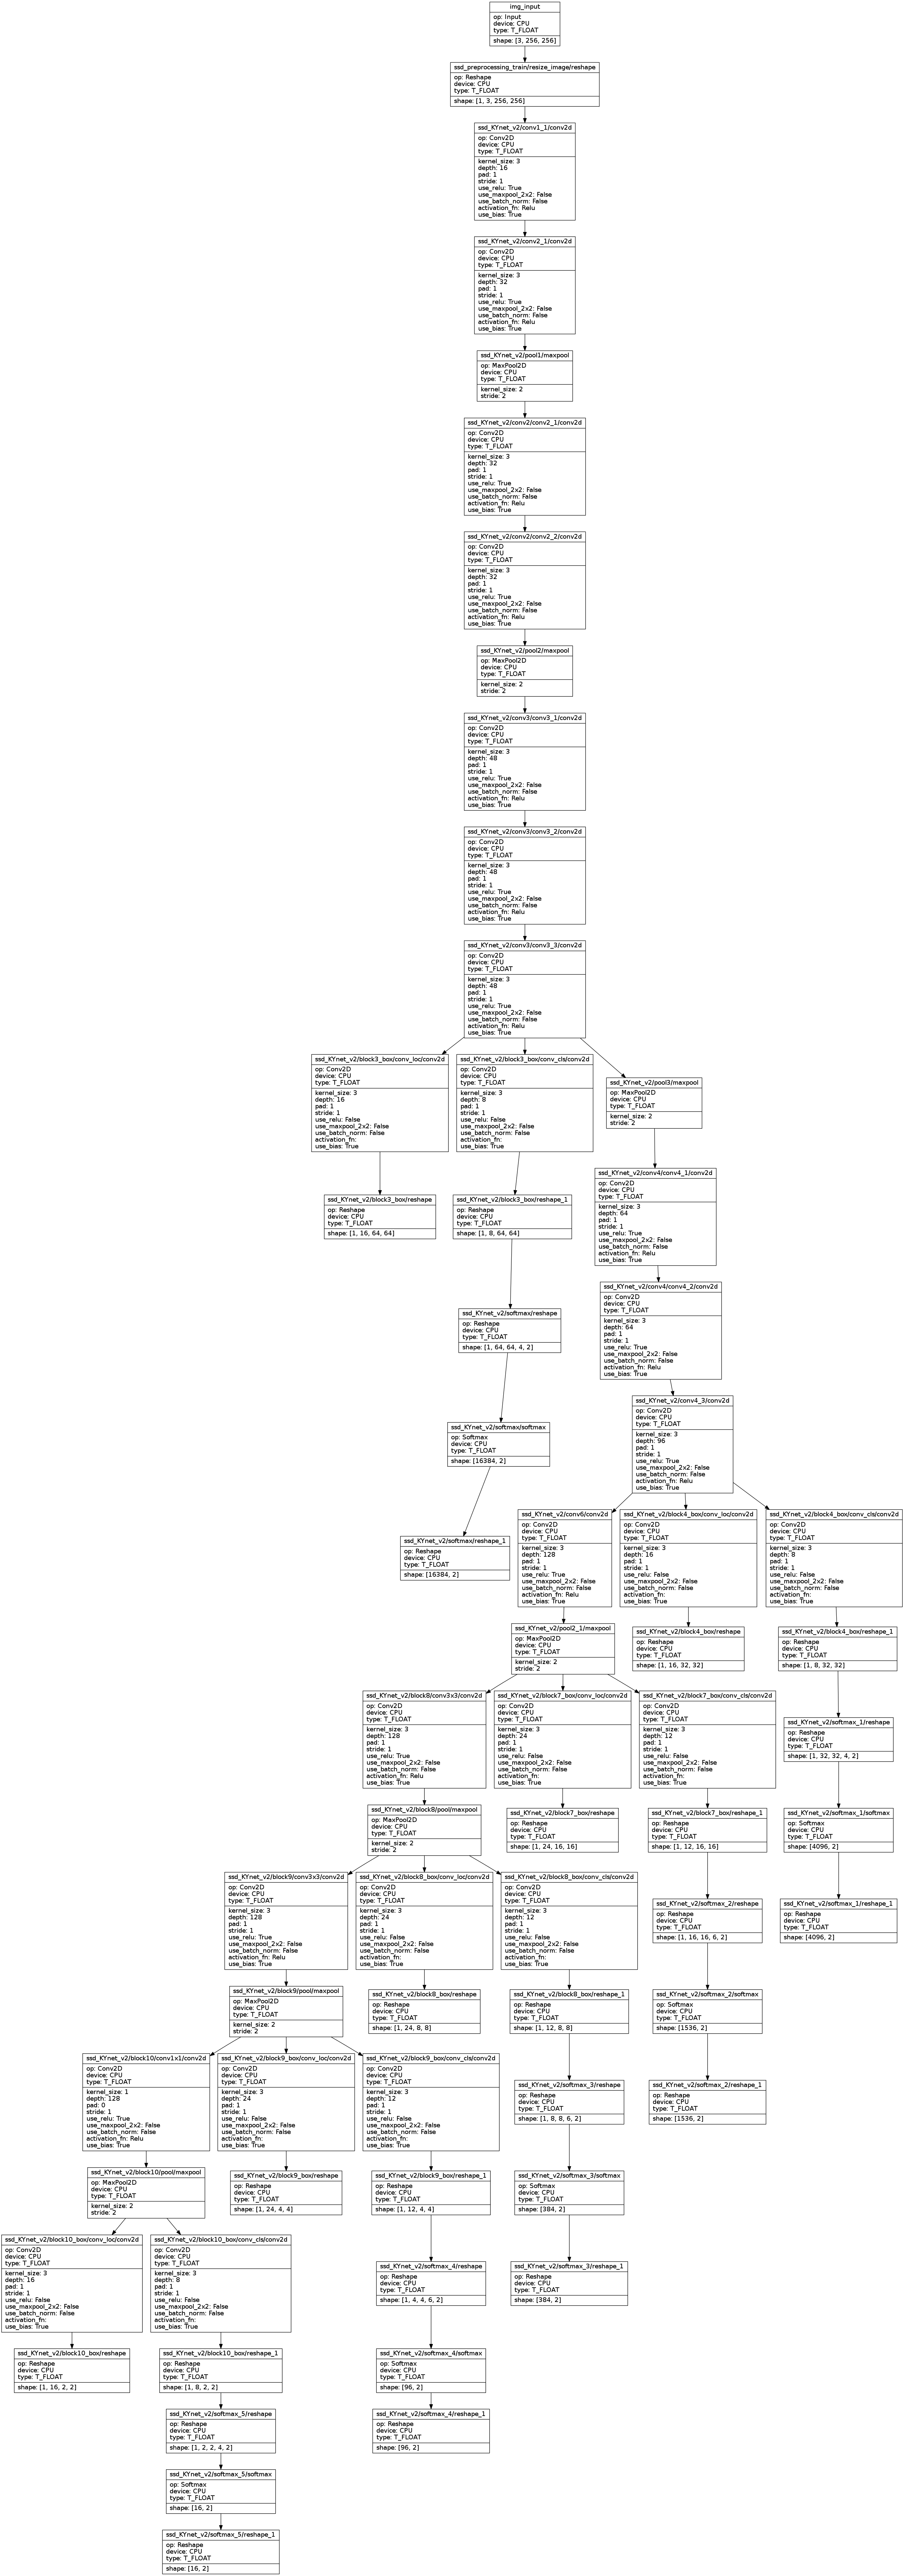

In [10]:
from PIL import Image
from plumber.utils import visualise_dfg

# Generate DFG IR png image
visualise_dfg('../data/ssd.pbtxt', '../data/ssd.png')

im = Image.open('../data/ssd.png')
# show
im

## Training by TensorFlow

Here we show a simple example, we use the MNIST network to train. First defining the MNIST network structure.

In [11]:
with open('../data/mnist.pbtxt', 'r') as f:
    print(f.read())

name: "CNN_MNIST"
node {
  name: "img_input"
  op: "Input"
  device: CPU
  type: T_FLOAT
  input_op_param {
    shape {
      dim: 50
      dim: 28
      dim: 28
      dim: 1
    }
  }
}
node {
  name: "conv1"
  input: "img_input"
  op: "Conv2D"
  device: CPU
  type: T_FLOAT
  conv2d_op_param {
    depth: 32
    kernel_size: 5
    pad: 2
    stride: 1
    activation_fn: "Relu"
    use_bias: true
  }
}
node {
  name: "pool1"
  input: "conv1"
  op: "MaxPool2D"
  device: CPU
  type: T_FLOAT
  max_pool2d_op_param {
    kernel_size: 2
    stride: 2
  }
}
node {
  name: "conv2"
  input: "pool1"
  op: "Conv2D"
  device: CPU
  type: T_FLOAT
  conv2d_op_param {
    depth: 64
    kernel_size: 5
    pad: 2
    stride: 1
    activation_fn: "Relu"
    use_bias: true
  }
}
node {
  name: "pool2"
  input: "conv2"
  op: "MaxPool2D"
  device: CPU
  type: T_FLOAT
  max_pool2d_op_param {
    kernel_size: 2
    stride: 2
  }
}
node {
  name: "flatten"
  input: "pool2"
  op: "Flatten"
  device: CPU
  type:

### Get Graph from Plumber

We use dfg_to_tf to get the Graph that defines the network model.

And can get its input and output Tensor, have them, you can do some data pre-processing and custom loss.

In [1]:
import tensorflow as tf
from plumber.utils import dfg_to_tf

# We use pbtxt to load the model and get a graph that defines the network model

graph = tf.Graph()
graph, output_nodes = dfg_to_tf('../data/mnist.pbtxt', graph)

images = graph.get_tensor_by_name("img_input:0")
print(images)

logits = output_nodes['cls_output_node']
print(logits)

Tensor("img_input:0", shape=(50, 28, 28, 1), dtype=float32)
Tensor("fc4/BiasAdd:0", shape=(50, 10), dtype=float32)


### Training

**Warning**: Because server resources are limited, Please do not perform training network operations here.

In [2]:
# Due to server resource issues, please try this on your own computer
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("../data/MNIST_data/", one_hot=True)

# Graph is a network diagram generated using Plumebr
with graph.as_default():
    labels = tf.placeholder(tf.float32, shape=[None, 10])
    keep_prob = tf.placeholder(tf.float32)
    
    # Nodes for training
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)
    train = tf.train.AdadeltaOptimizer(1e-3).minimize(loss)
    
    # accuracy
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    saver = tf.train.Saver()
    
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())

        for i in range(20000):
            batch_xs, batch_ys = mnist.train.next_batch(50)
            imgs = batch_xs.reshape((50, 28, 28, 1))
            _, loss_val = sess.run([train, loss],
                                   feed_dict={images: imgs,
                                              labels: batch_ys,
                                              keep_prob: 0.5})
        
            if i % 100 == 0:
                print('Loss value of a training batch at step %5d: %f' % (i, np.mean(loss_val)))
            if i % 1000 == 0:
                batch_x_test, batch_y_test = mnist.train.next_batch(50)
                acc = sess.run(accuracy,
                               feed_dict={images: batch_x_test.reshape((50, 28, 28, 1)),
                                          labels: batch_y_test,
                                          keep_prob: 1.0})
                print('Accuracy after running %5d steps: %f' % (i, acc))
        total_acc = 0
        for i in range(200):
            batch_x_test, batch_y_test = mnist.train.next_batch(50)
            acc = sess.run(accuracy,
                           feed_dict={images: batch_x_test.reshape((50, 28, 28, 1)),
                                      labels: batch_y_test,
                                      keep_prob: 1.0})
            total_acc += acc
        print('Accuracy after running 20000 steps: %f' % (total_acc/200))
        # save the trained model
        saver.save(sess, "mnist_lenet_logs/mnist_net.ckpt")

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz
Loss value of a training batch at step     0: 2.286170
Accuracy after running     0 steps: 0.140000
Loss value of a training batch at step   100: 2.286594
Loss value of a training batch at step   200: 2.286906
Loss value of a training batch at step   300: 2.279326
Loss value of a training batch at step   400: 2.270366
Loss value of a training batch at step   500: 2.266109
Loss value of a training batch at step   600: 2.240665
Loss value of a training batch at step   700: 2.251173
Loss value of a training batch at step   800: 2.233912
Loss value of a training batch at step   900: 2.216084
Loss value of a training batch at step  1000: 2.217929
Accuracy after running  1000 steps: 0.420000
Loss value of a training batch at step  1100: 2.205479
Loss value of a training

Loss value of a training batch at step 13400: 0.672461
Loss value of a training batch at step 13500: 0.742156
Loss value of a training batch at step 13600: 0.575663
Loss value of a training batch at step 13700: 0.703015
Loss value of a training batch at step 13800: 0.575930
Loss value of a training batch at step 13900: 0.629517
Loss value of a training batch at step 14000: 0.709459
Accuracy after running 14000 steps: 0.840000
Loss value of a training batch at step 14100: 0.675367
Loss value of a training batch at step 14200: 0.600971
Loss value of a training batch at step 14300: 0.511204
Loss value of a training batch at step 14400: 0.564078
Loss value of a training batch at step 14500: 0.547255
Loss value of a training batch at step 14600: 0.576333
Loss value of a training batch at step 14700: 0.456705
Loss value of a training batch at step 14800: 0.656424
Loss value of a training batch at step 14900: 0.611884
Loss value of a training batch at step 15000: 0.655859
Accuracy after runni

In [3]:
# Make sure that mnist_lenet_log, the directory contains trained model, exists.
!file mnist_lenet_log/

mnist_lenet_log/: directory
